In [ ]:
!pip install -q torchinfo

In [ ]:
!pip install torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
from torchinfo import summary

In [ ]:
!unzip drive/My\ Drive/test.zip

Archive:  drive/My Drive/test.zip
   creating: test/
   creating: test/Rice Leaf Disease Images/
   creating: test/Rice Leaf Disease Images/Bacterialblight/
  inflating: test/Rice Leaf Disease Images/Bacterialblight/BACTERAILBLIGHT3_001.jpg  
  inflating: test/Rice Leaf Disease Images/Bacterialblight/BACTERAILBLIGHT3_010.jpg  
  inflating: test/Rice Leaf Disease Images/Bacterialblight/BACTERAILBLIGHT3_011.jpg  
  inflating: test/Rice Leaf Disease Images/Bacterialblight/BACTERAILBLIGHT3_012.jpg  
  inflating: test/Rice Leaf Disease Images/Bacterialblight/BACTERAILBLIGHT3_013.jpg  
  inflating: test/Rice Leaf Disease Images/Bacterialblight/BACTERAILBLIGHT3_022.jpg  
  inflating: test/Rice Leaf Disease Images/Bacterialblight/BACTERAILBLIGHT3_023.jpg  
  inflating: test/Rice Leaf Disease Images/Bacterialblight/BACTERAILBLIGHT3_024.jpg  
  inflating: test/Rice Leaf Disease Images/Bacterialblight/BACTERAILBLIGHT3_025.jpg  
  inflating: test/Rice Leaf Disease Images/Bacterialblight/BACTERAILB

In [ ]:
!unzip drive/My\ Drive/leaf.zip

Streaming output truncated to the last 5000 lines.
  inflating: Rice Leaf Disease Images/Bacterialblight/BACTERIALBLIGHT1_141.JPG  
  inflating: Rice Leaf Disease Images/Bacterialblight/BACTERIALBLIGHT1_142.JPG  
  inflating: Rice Leaf Disease Images/Bacterialblight/BACTERIALBLIGHT1_143.JPG  
  inflating: Rice Leaf Disease Images/Bacterialblight/BACTERIALBLIGHT1_144.JPG  
  inflating: Rice Leaf Disease Images/Bacterialblight/BACTERIALBLIGHT1_145.JPG  
  inflating: Rice Leaf Disease Images/Bacterialblight/BACTERIALBLIGHT1_146.JPG  
  inflating: Rice Leaf Disease Images/Bacterialblight/BACTERIALBLIGHT1_147.jpg  
  inflating: Rice Leaf Disease Images/Bacterialblight/BACTERIALBLIGHT1_148.jpg  
  inflating: Rice Leaf Disease Images/Bacterialblight/BACTERIALBLIGHT1_149.jpg  
  inflating: Rice Leaf Disease Images/Bacterialblight/BACTERIALBLIGHT1_150.jpg  
  inflating: Rice Leaf Disease Images/Bacterialblight/BACTERIALBLIGHT1_151.jpg  
  inflating: Rice Leaf Disease Images/Bacterialblight/BACT

In [ ]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.flags = True
torch.backends.cudnn.pad_conv_inference = True
torch.backends.cudnn.use_fastest = True
torch.backends.cudnn.version = True

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
np.random.seed(0)
torch.manual_seed(0)
%matplotlib inline
sns.set_style('darkgrid')

image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
}
rps_dataset = datasets.ImageFolder(root = "/content/Rice Leaf Disease Images",
                                   transform = image_transforms["train"]
                                  )
rps_dataset
rps_dataset.class_to_idx
idx2class = {v: k for k, v in rps_dataset.class_to_idx.items()}
idx2class

{0: 'Bacterialblight', 1: 'Blast', 2: 'Brownspot', 3: 'Tungro'}

Text(0.5, 1.0, 'Entire Dataset (before train/val/test split)')

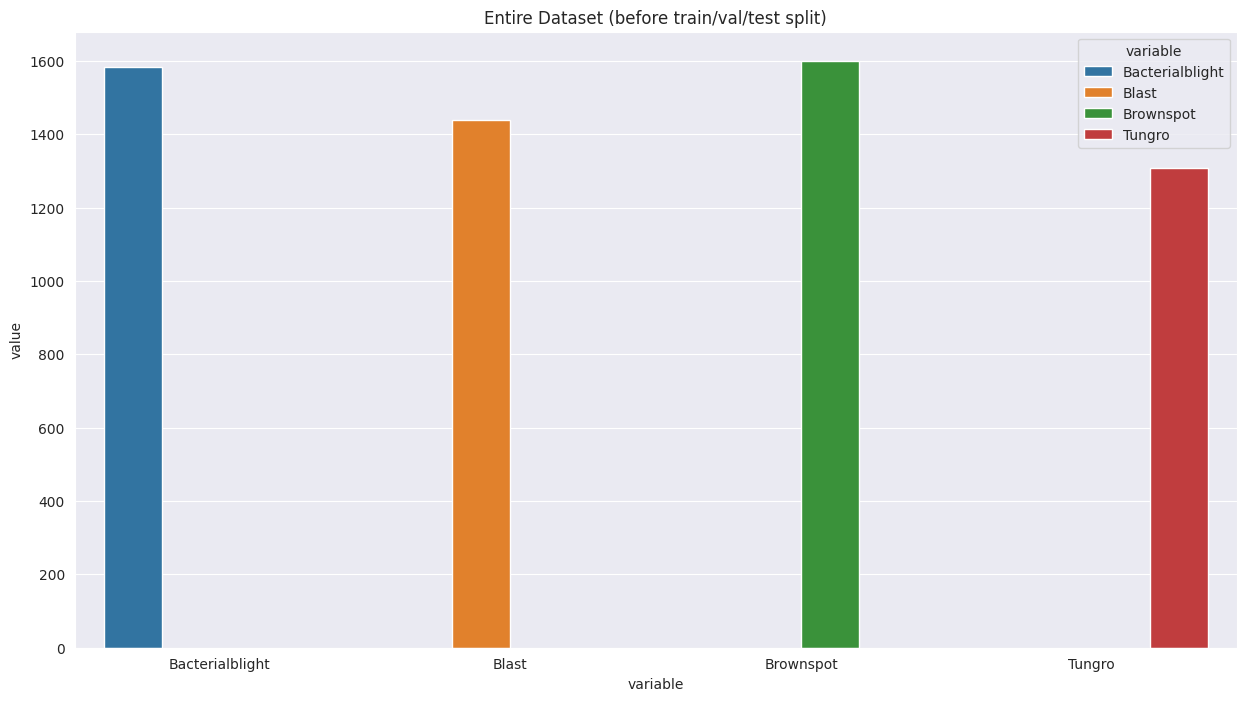

In [ ]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(rps_dataset), plot_title="Entire Dataset (before train/val/test split)")

In [ ]:
rps_dataset_size = len(rps_dataset)
print(rps_dataset_size)

rps_dataset_indices = list(range(rps_dataset_size))
np.random.shuffle(rps_dataset_indices)
val_split_index = int(np.floor(0.2 * rps_dataset_size))
train_idx, val_idx = rps_dataset_indices[:5500], rps_dataset_indices[5500:5900]
print(len(train_idx), len(val_idx))

5932
5500 400


In [ ]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
rps_dataset_test = datasets.ImageFolder(root = "/content/test/Rice Leaf Disease Images",
                                        transform = image_transforms["test"])
s=len(rps_dataset_test)

rps_dataset_test.class_to_idx
idx2class = {v: k for k, v in rps_dataset_test.class_to_idx.items()}
idx2class

{0: 'Bacterialblight', 1: 'Blast', 2: 'Brownspot', 3: 'Tungro'}

In [ ]:
rps_dataset_test_indices = list(range(s))
test_idx=rps_dataset_test_indices[:3000]
print(len(test_idx))
test_sampler = SubsetRandomSampler(test_idx)

3000


In [ ]:
train_loader = DataLoader(dataset=rps_dataset, shuffle=False, batch_size=50, sampler=train_sampler)
val_loader = DataLoader(dataset=rps_dataset, shuffle=False, batch_size=50, sampler=val_sampler)
test_loader = DataLoader(dataset=rps_dataset_test, shuffle=False, batch_size=50,sampler=test_sampler)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

In [ ]:
training_dataset=rps_dataset

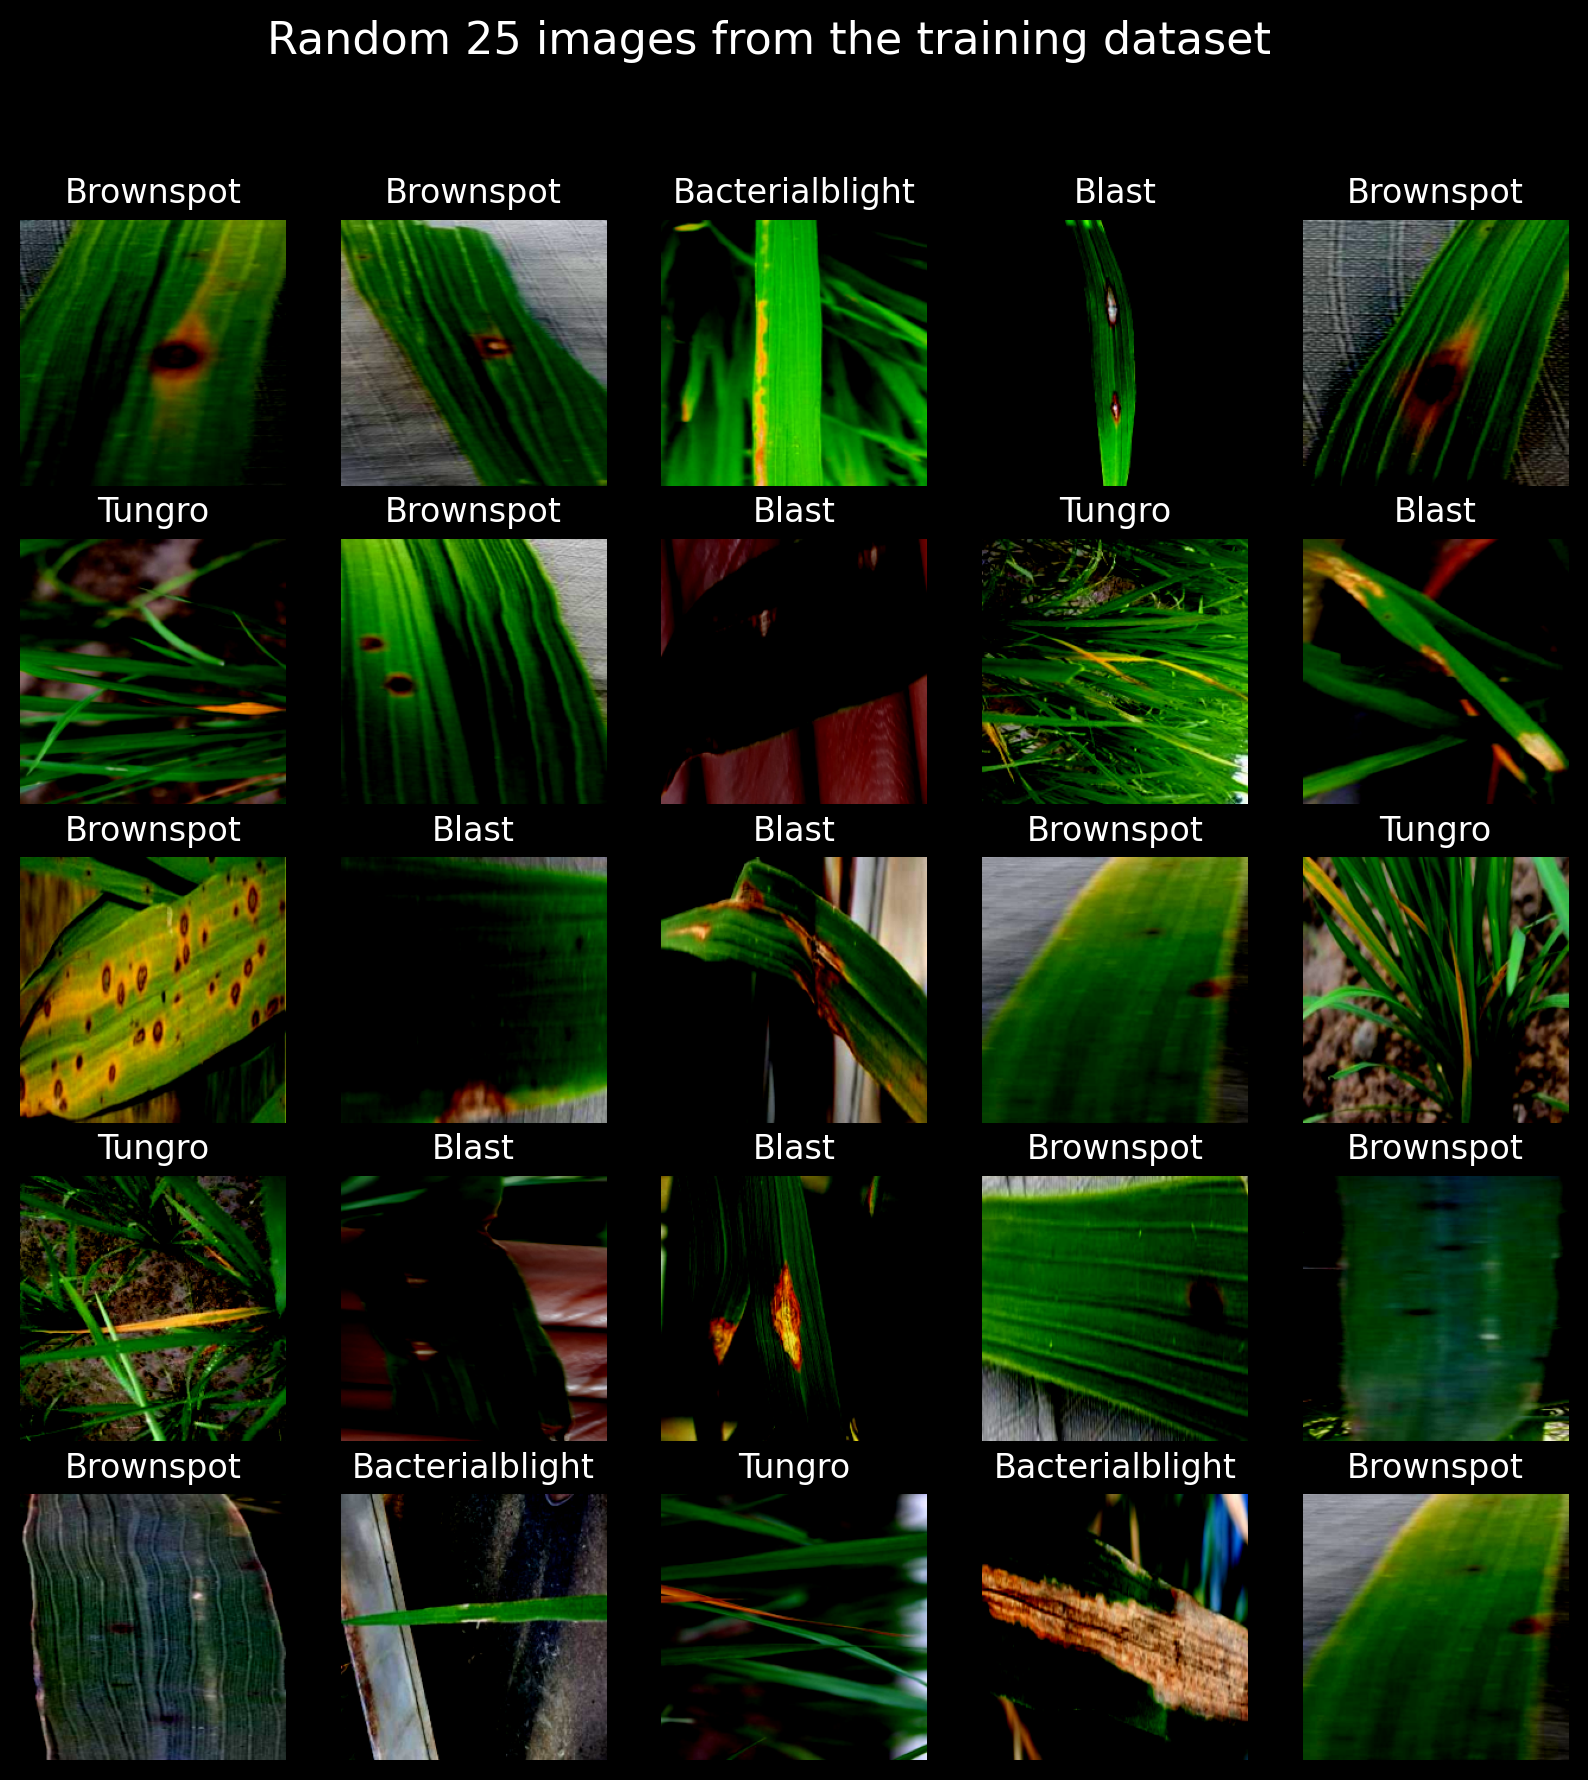

In [ ]:
import matplotlib.pyplot as plt
import random

num_rows = 5
num_cols = num_rows

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the subplots and display random images from the training dataset
for i in range(num_rows):
    for j in range(num_cols):
        # Choose a random index from the training dataset
        image_index = random.randrange(len(training_dataset))

        # Display the image in the subplot
        axs[i, j].imshow(training_dataset[image_index][0].permute((1, 2, 0)))

        # Set the title of the subplot as the corresponding class name
        axs[i, j].set_title(training_dataset.classes[training_dataset[image_index][1]], color="white")

        # Disable the axis for better visualization
        axs[i, j].axis(False)

# Set the super title of the figure
fig.suptitle(f"Random {num_rows * num_cols} images from the training dataset", fontsize=16, color="white")

# Set the background color of the figure as black
fig.set_facecolor(color='black')

# Display the plot
plt.show()

In [ ]:
BATCH_SIZE=50
PATCH_SIZE = 16
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 3
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)

#the image width and image height should be divisible by patch size. This is a check to see that.

assert IMAGE_WIDTH % PATCH_SIZE == 0 and IMAGE_HEIGHT % PATCH_SIZE ==0 , print("Image Width is not divisible by patch size")

In [ ]:
conv_layer = nn.Conv2d(in_channels = IMAGE_CHANNELS, out_channels = EMBEDDING_DIMS, kernel_size = PATCH_SIZE, stride = PATCH_SIZE)



In [ ]:
conv_layer = nn.Conv2d(in_channels = IMAGE_CHANNELS, out_channels = EMBEDDING_DIMS, kernel_size = PATCH_SIZE, stride = PATCH_SIZE)

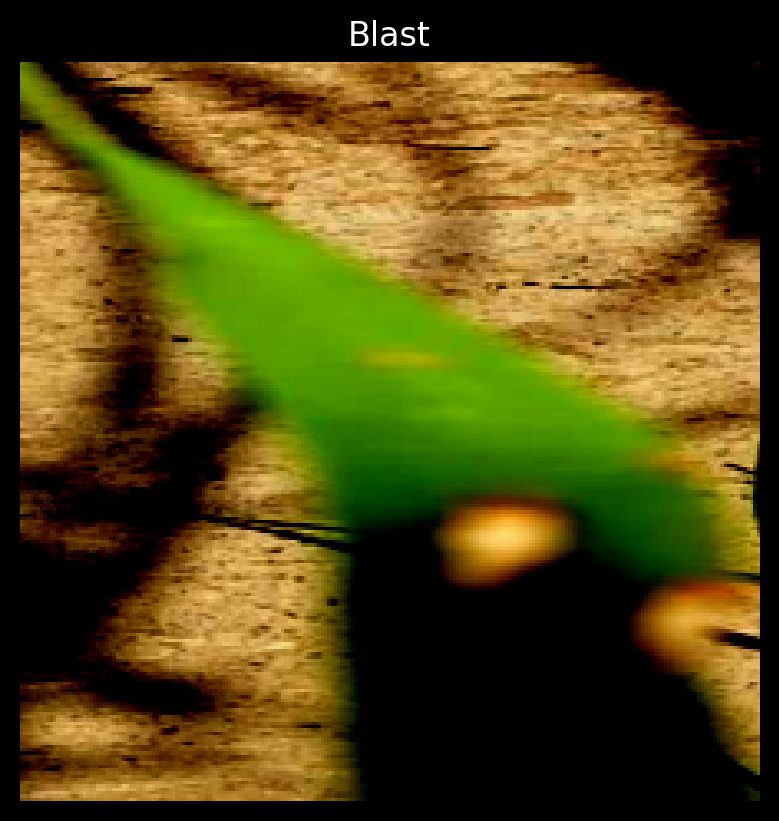

In [ ]:
random_images, random_labels = next(iter(train_loader))
random_image = random_images[0]

# Create a new figure
fig = plt.figure(1)

# Display the random image
plt.imshow(random_image.permute((1, 2, 0)))

# Disable the axis for better visualization
plt.axis(False)

# Set the title of the image
plt.title(training_dataset.classes[random_labels[0]], color="white")

# Set the background color of the figure as black
fig.set_facecolor(color="black")

In [ ]:
# Pass the image through the convolution layer
image_through_conv = conv_layer(random_image.unsqueeze(0))
print(f'Shape of embeddings through the conv layer -> {list(image_through_conv.shape)} <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]')

# Permute the dimensions of image_through_conv to match the expected shape
image_through_conv = image_through_conv.permute((0, 2, 3, 1))

# Create a flatten layer using nn.Flatten
flatten_layer = nn.Flatten(start_dim=1, end_dim=2)

# Pass the image_through_conv through the flatten layer
image_through_conv_and_flatten = flatten_layer(image_through_conv)

# Print the shape of the embedded image
print(f'Shape of embeddings through the flatten layer -> {list(image_through_conv_and_flatten.shape)} <- [batch_size, num_of_patches, embedding_dims]')

# Assign the embedded image to a variable
embedded_image = image_through_conv_and_flatten

Shape of embeddings through the conv layer -> [1, 768, 14, 14] <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]
Shape of embeddings through the flatten layer -> [1, 196, 768] <- [batch_size, num_of_patches, embedding_dims]


In [ ]:
class_token_embeddings = nn.Parameter(torch.rand((1, 1,EMBEDDING_DIMS), requires_grad  = True))
print(f'Shape of class_token_embeddings --> {list(class_token_embeddings.shape)} <-- [batch_size, 1, emdedding_dims]')

embedded_image_with_class_token_embeddings = torch.cat((class_token_embeddings, embedded_image), dim = 1)
print(f'\nShape of image embeddings with class_token_embeddings --> {list(embedded_image_with_class_token_embeddings.shape)} <-- [batch_size, num_of_patches+1, embeddiing_dims]')

position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES+1, EMBEDDING_DIMS ), requires_grad = True ))
print(f'\nShape of position_embeddings --> {list(position_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

final_embeddings = embedded_image_with_class_token_embeddings + position_embeddings
print(f'\nShape of final_embeddings --> {list(final_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

Shape of class_token_embeddings --> [1, 1, 768] <-- [batch_size, 1, emdedding_dims]

Shape of image embeddings with class_token_embeddings --> [1, 197, 768] <-- [batch_size, num_of_patches+1, embeddiing_dims]

Shape of position_embeddings --> [1, 197, 768] <-- [batch_size, num_patches+1, embeddings_dims]

Shape of final_embeddings --> [1, 197, 768] <-- [batch_size, num_patches+1, embeddings_dims]


In [ ]:
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim,):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.rand((BATCH_SIZE, 1, EMBEDDING_DIMS), requires_grad=True))
        self.position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True))

    def forward(self, x):
        output = torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1) + self.position_embeddings
        return output

In [ ]:
patch_embedding_layer = PatchEmbeddingLayer(in_channels=IMAGE_CHANNELS, patch_size=PATCH_SIZE, embedding_dim=IMAGE_CHANNELS * PATCH_SIZE ** 2)

patch_embeddings = patch_embedding_layer(random_images)
patch_embeddings.shape

torch.Size([50, 197, 768])

In [ ]:
summary(model=patch_embedding_layer,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, input_channels, img_width, img_height)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
PatchEmbeddingLayer (PatchEmbeddingLayer)     [50, 3, 224, 224]    [50, 197, 768]       189,696              True
├─Conv2d (conv_layer)                         [50, 3, 224, 224]    [50, 768, 14, 14]    590,592              True
├─Flatten (flatten_layer)                     [50, 14, 14, 768]    [50, 196, 768]       --                   --
Total params: 780,288
Trainable params: 780,288
Non-trainable params: 0
Total mult-adds (G): 5.79
Input size (MB): 30.11
Forward/backward pass size (MB): 60.21
Params size (MB): 2.36
Estimated Total Size (MB): 92.68

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dims = 768, # Hidden Size D in the ViT Paper Table 1
               num_heads = 12,  # Heads in the ViT Paper Table 1
               attn_dropout = 0.0 # Default to Zero as there is no dropout for the the MSA Block as per the ViT Paper
               ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                     embed_dim = embedding_dims,
                                                     dropout = attn_dropout,
                                                     batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dims = 768, # Hidden Size D in the ViT Paper Table 1
               num_heads = 12,  # Heads in the ViT Paper Table 1
               attn_dropout = 0.0 # Default to Zero as there is no dropout for the the MSA Block as per the ViT Paper
               ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                     embed_dim = embedding_dims,
                                                     dropout = attn_dropout,
                                                     batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output

In [ ]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dims = EMBEDDING_DIMS,
                                                             num_heads = 12
                                                             )
print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from MSA Block => {list(multihead_self_attention_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')

Shape of the input Patch Embeddings => [50, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from MSA Block => [50, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]


In [ ]:
summary(model=multihead_self_attention_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MultiHeadSelfAttentionBlock (MultiHeadSelfAttentionBlock)    [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layernorm)                                      [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (multiheadattention)                    --                   [1, 197, 768]        2,362,368            True
Total params: 2,363,904
Trainable params: 2,363,904
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 1.21
Params size (MB): 0.01
Estimated Total Size (MB): 1.82

In [ ]:
class MachineLearningPerceptronBlock(nn.Module):
  def __init__(self, embedding_dims, mlp_size, mlp_dropout):
    super().__init__()
    self.embedding_dims = embedding_dims
    self.mlp_size = mlp_size
    self.dropout = mlp_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dims, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = mlp_dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dims),
        nn.Dropout(p = mlp_dropout)
    )

  def forward(self, x):
    return self.mlp(self.layernorm(x))

In [ ]:
mlp_block = MachineLearningPerceptronBlock(embedding_dims = EMBEDDING_DIMS,
                                           mlp_size = 3072,
                                           mlp_dropout = 0.1)

summary(model=mlp_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MachineLearningPerceptronBlock (MachineLearningPerceptronBlock)   [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layernorm)                                           [1, 197, 768]        [1, 197, 768]        1,536                True
├─Sequential (mlp)                                                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─Linear (0)                                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
│    └─GELU (1)                                                   [1, 197, 3072]       [1, 197, 3072]       --                   --
│    └─Dropout (2)                                                [1, 197, 3072]       [1, 197, 3072]       --                   --
│    └─Linear (3)                                            

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, embedding_dims = 768,
               mlp_dropout=0.1,
               attn_dropout=0.0,
               mlp_size = 3072,
               num_heads = 12,
               ):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    self.mlp_block = MachineLearningPerceptronBlock(embedding_dims = embedding_dims,
                                                    mlp_size = mlp_size,
                                                    mlp_dropout = mlp_dropout,
                                                    )

  def forward(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x

    return x

In [ ]:
transformer_block = TransformerBlock(embedding_dims = EMBEDDING_DIMS,
                                     mlp_dropout = 0.1,
                                     attn_dropout=0.0,
                                     mlp_size = 3072,
                                     num_heads = 12)

print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from Transformer Block => {list(transformer_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')

Shape of the input Patch Embeddings => [50, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from Transformer Block => [50, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]


In [ ]:
summary(model=transformer_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerBlock (TransformerBlock)                [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multiheadattention)     --                   [1, 197, 768]        2,362,368            True
├─MachineLearningPerceptronBlock (mlp_block)       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [ ]:
class ViT(nn.Module):
  def __init__(self, img_size = 224,
               in_channels = 3,
               patch_size = 16,
               embedding_dims = 768,
               num_transformer_layers = 12, # from table 1 above
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3072,
               num_heads = 12,
               num_classes = 4):
    super(ViT,self).__init__()

    self.patch_embedding_layer = PatchEmbeddingLayer(in_channels = in_channels,
                                                     patch_size=patch_size,
                                                     embedding_dim = embedding_dims)

    self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims,
                                              mlp_dropout = mlp_dropout,
                                              attn_dropout = attn_dropout,
                                              mlp_size = mlp_size,
                                              num_heads = num_heads) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
                                    nn.Linear(in_features = embedding_dims,
                                              out_features = num_classes))

  def forward(self, x):
    return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])

In [ ]:
v=ViT()
print(v)

ViT(
  (patch_embedding_layer): PatchEmbeddingLayer(
    (conv_layer): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten_layer): Flatten(start_dim=1, end_dim=2)
  )
  (transformer_encoder): Sequential(
    (0): TransformerBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multiheadattention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MachineLearningPerceptronBlock(
        (layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): Transform

In [ ]:
summary(model=v,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [50, 3, 224, 224]    [50, 4]              --                   True
├─PatchEmbeddingLayer (patch_embedding_layer)                [50, 3, 224, 224]    [50, 197, 768]       189,696              True
│    └─Conv2d (conv_layer)                                   [50, 3, 224, 224]    [50, 768, 14, 14]    590,592              True
│    └─Flatten (flatten_layer)                               [50, 14, 14, 768]    [50, 196, 768]       --                   --
├─Sequential (transformer_encoder)                           [50, 197, 768]       [50, 197, 768]       --                   True
│    └─TransformerBlock (0)                                  [50, 197, 768]       [50, 197, 768]       --                   True
│    │    └─MultiHeadSelfAttentionBlock (msa_block)          [50, 197, 768]       [50, 197, 76

In [ ]:
import torch.optim as optim
v.parameters()

<generator object Module.parameters at 0x7eeff824b4c0>

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(v.parameters(),lr=.001,momentum=0.9)

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
accuracy_stats = {
    'train' : [],
    'val' : []
}

loss_stats = {
    'train':[],
    'val':[]
}
def multi_acc(y_pred,y_test):
  y_pred_softmax = torch.log_softmax(y_pred,dim=1)
  _,y_pred_tags = torch.max(y_pred_softmax,dim=1)
  correc_pred = (y_pred_tags==y_test).float()
  acc= correc_pred.sum()/len(correc_pred)
  acc = torch.round(acc*100)
  return acc

In [ ]:
print("Begin training.")
for e in tqdm(range(1, 11)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    v.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = v(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    # VALIDATION
    with torch.no_grad():
        v.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = v(X_val_batch)
            #y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


 10%|█         | 1/10 [03:42<33:26, 222.95s/it]

Epoch 01: | Train Loss: 0.29736 | Val Loss: 0.14190 | Train Acc: 87.836| Val Acc: 96.000


 20%|██        | 2/10 [07:23<29:30, 221.30s/it]

Epoch 02: | Train Loss: 0.19369 | Val Loss: 0.20565 | Train Acc: 92.818| Val Acc: 92.000


 30%|███       | 3/10 [11:03<25:46, 220.93s/it]

Epoch 03: | Train Loss: 0.18941 | Val Loss: 0.21052 | Train Acc: 92.855| Val Acc: 90.000


 40%|████      | 4/10 [14:44<22:04, 220.81s/it]

Epoch 04: | Train Loss: 0.13658 | Val Loss: 0.15407 | Train Acc: 95.145| Val Acc: 94.000


 50%|█████     | 5/10 [18:24<18:23, 220.66s/it]

Epoch 05: | Train Loss: 0.09571 | Val Loss: 0.03461 | Train Acc: 96.745| Val Acc: 100.000


 60%|██████    | 6/10 [22:04<14:42, 220.53s/it]

Epoch 06: | Train Loss: 0.08706 | Val Loss: 0.07101 | Train Acc: 96.873| Val Acc: 98.000


 70%|███████   | 7/10 [25:45<11:01, 220.44s/it]

Epoch 07: | Train Loss: 0.04226 | Val Loss: 0.02066 | Train Acc: 98.818| Val Acc: 100.000


 80%|████████  | 8/10 [29:25<07:20, 220.47s/it]

Epoch 08: | Train Loss: 0.02420 | Val Loss: 0.02194 | Train Acc: 99.236| Val Acc: 100.000


 90%|█████████ | 9/10 [33:06<03:40, 220.50s/it]

Epoch 09: | Train Loss: 0.01706 | Val Loss: 0.02953 | Train Acc: 99.545| Val Acc: 98.000


100%|██████████| 10/10 [36:46<00:00, 220.66s/it]

Epoch 10: | Train Loss: 0.00463 | Val Loss: 0.00210 | Train Acc: 99.927| Val Acc: 100.000


In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
loss_values = []
acc_values = []

start.record()

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    train_epoch_loss= 0
    train_epoch_acc = 0
    for i, (inputs,labels) in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = v(inputs)
        loss = criterion(outputs, labels)
        train_acc=multi_acc(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())
        acc_values.append( train_acc.item())
        train_epoch_loss += loss.item()
        train_epoch_acc += train_acc.item()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            print('[%d, %5d] accuracy: %.3f' %
                  (epoch + 1, i + 1,  train_epoch_acc / 50))
            running_loss = 0.0
            train_epoch_acc = 0
    with torch.no_grad():
      v.eval()

      val_epoch_loss = 0
      val_epoch_acc= 0
      for j, (vinputs,vlabels) in enumerate(val_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)


        # forward + backward + optimize
        voutputs = v(inputs)
        vloss = criterion(voutputs, vlabels)
        vtrain_acc=multi_acc(voutputs, vlabels)


        val_epoch_loss += vloss.item()
        val_epoch_acc+= vtrain_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    print(f'Epoch {epoch+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')



# whatever you are timing goes here
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))

In [ ]:
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss')
plt.plot(range(1, len(acc_values) + 1), acc_values, label='Training accuracy')
plt.title('Training Loss Over Batches')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

NameError: ignored

In [ ]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(val_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = v(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
y_true_list=list(np.concatenate([arr.ravel() for arr in y_true_list]))
y_pred_list=list(np.concatenate([arr.ravel() for arr in y_pred_list]))
len(y_true_list)

400

In [ ]:
print(confusion_matrix(y_true_list, y_pred_list))

[[103   0   0   0]
 [  0  99   0   0]
 [  0   0 102   0]
 [  0   0   0  96]]


<Axes: >

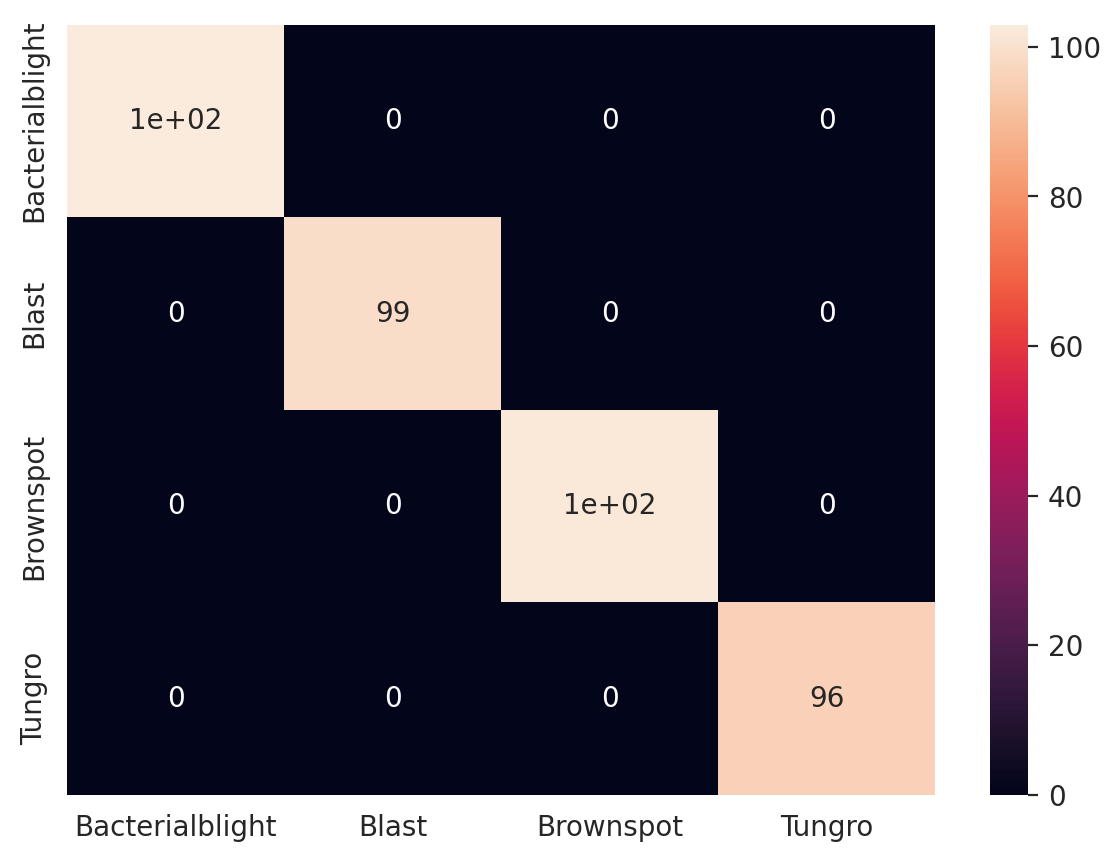

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

In [ ]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00       102
           3       1.00      1.00      1.00        96

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

